<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/02_Evaluate_3B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B/3B Evaluation
## 02 - Comprehensive Benchmark Suite Evaluation

### Exploring GLU Expansion Ratios in Llama-3.2 Models
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** GPU L4 (or T4)

**Models to Evaluate:**
* Llama-3.2-1B (base) - Baseline
* Llama-3.2-1B-pruned-20% (220% expansion)
* Llama-3.2-1B-pruned-40% (140% expansion) ⭐ Star model
* Llama-3.2-1B-pruned-60% (60% expansion)

**Benchmarks (10 total):**
* WikiText-2 Perplexity (0-shot)
* BoolQ (0-shot)
* Lambada-OpenAI (0-shot)
* MMLU (5-shot)
* ARC-Challenge (0-shot)
* HellaSwag (0-shot)
* WinoGrande (0-shot)
* PIQA (0-shot)
* TruthfulQA MC1/MC2 (0-shot)
* GSM8K (5-shot CoT)

**Estimated Runtime:** ~4-5 hours total

---

## 📋 Notebook Objective

This notebook conducts a comprehensive evaluation of the Llama-3.2-1B/3B model family across three pruning levels (20%, 40%, 60%) to determine:

1. **Performance degradation patterns** across different pruning intensities
2. **Optimal expansion ratio** for GLU-MLP layers (hypothesis: 140%)
3. **Task-specific resilience** to pruning (knowledge vs. algorithmic tasks)
4. **Which models merit uploading to HuggingFace Hub** for Phase 2

### Key Features:
- ✅ **Checkpoint/Resume Support:** Survives Colab disconnections
- ✅ **On-the-fly Pruning:** No need to pre-create models
- ✅ **Robust Error Handling:** Continues if individual benchmarks fail
- ✅ **Progress Tracking:** Live updates and detailed logging

### Results will answer:
- Does 40% pruning (140% expansion) truly outperform other levels?
- Which benchmarks are most sensitive to pruning?
- Should we upload non-star models to HF, or only the 40% version?

---

**Note:** This evaluation uses the MAW (Maximum Absolute Weight) neuron selection method, validated in Notebook 00 as the optimal approach for GLU architectures.

---

# 1. Setup & Installation

In [1]:
# Install required libraries
!pip install -q optipfair
!pip install -q lm-eval
!pip install -q langdetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Mount Google Drive for checkpoint persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

✅ utils.py downloaded successfully


In [4]:
# Import core libraries and utilities
import torch
import json
import pandas as pd
from datetime import datetime
from pathlib import Path

# Import our utility functions
from utils import (
    EXPERIMENT_CONFIG,
    BENCHMARKS_BASE,
    load_or_create_model,
    run_robust_evaluation,
    clear_gpu_cache,
    get_model_stats,
    format_results_table
)

print("✅ All imports successful")
print(f"📱 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful
📱 Device: GPU
   GPU: NVIDIA L4
   Memory: 23.8 GB


# 2. Configuration & Planning

This section filters the experiment configuration for 1B/3B models and displays the evaluation plan.

In [5]:
# Filter configuration for 1B models only
#models_1b = [
#    config for config in EXPERIMENT_CONFIG
#    if "1B" in config["base_model"] and "3B" not in config["base_model"]
#]

# Setup checkpoint paths
#CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints/1b"
#RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Define checkpoint paths for each model
#checkpoint_paths = {
#    "baseline": f"{CHECKPOINT_DIR}/llama_3.2_1b_baseline.json",
#    "10pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_10pct.json",
#    "20pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_20pct.json",
#    "30pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_30pct.json",
#    "40pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_40pct.json",
#    "50pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_50pct.json",
#    "60pct": f"{CHECKPOINT_DIR}/llama_3.2_1b_pruned_60pct.json",
#}

#BASE_MODEL_ID = "meta-llama/Llama-3.2-1B"


In [6]:
# Filter configuration for 3B models only
models_1b = [
    config for config in EXPERIMENT_CONFIG
    if "3B" in config["base_model"] and "1B" not in config["base_model"]
]

CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints/3b"
RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Define checkpoint paths for each model
checkpoint_paths = {
    "baseline": f"{CHECKPOINT_DIR}/llama_3.2_3b_baseline.json",
    "10pct": f"{CHECKPOINT_DIR}/llama_3.2_3b_pruned_10pct.json",
    "20pct": f"{CHECKPOINT_DIR}/llama_3.2_3b_pruned_20pct.json",
    "30pct": f"{CHECKPOINT_DIR}/llama_3.2_3b_pruned_30pct.json",
    "40pct": f"{CHECKPOINT_DIR}/llama_3.2_3b_pruned_40pct.json",
    "50pct": f"{CHECKPOINT_DIR}/llama_3.2_3b_pruned_50pct.json",
    "60pct": f"{CHECKPOINT_DIR}/llama_3.2_3b_pruned_60pct.json",
}

BASE_MODEL_ID = "meta-llama/Llama-3.2-3B"

In [7]:

print(f"\n{'='*70}")
print("📊 EVALUATION PLAN: Llama-3.2-1B/3B Family")
print(f"{'='*70}\n")

print(f"Total models to evaluate: {len(models_1b) + 1}")  # +1 for base model
print(f"Benchmarks per model: {len(BENCHMARKS_BASE)}")
print(f"Total evaluations: {(len(models_1b) + 1) * len(BENCHMARKS_BASE)}")
print(f"Estimated runtime: ~4-5 hours\n")

# Display models table
print("Models to evaluate:")
print("-" * 70)
print(f"{'Model':<30} {'Pruning':<10} {'Star':<6}")
print("-" * 70)
print(f"{'Llama-3.2 (baseline)':<30} {'0%':<10} {'N/A':<6}")
for config in models_1b:
    model_name = config['hf_repo_id'].split('/')[-1]
    pruning = f"{config['pruning_pct']}%"
    star = "⭐ Yes" if config['is_star'] else "No"
    print(f"{model_name:<30} {pruning:<10} {star:<6}")
print("-" * 70)

# Display benchmarks
print("\nBenchmarks to run:")
print("-" * 70)
for i, task in enumerate(BENCHMARKS_BASE, 1):
    task_name = task['name']
    fewshot = f"{task['num_fewshot']}-shot"
    print(f"{i:2d}. {task_name:<25} {fewshot}")
print("-" * 70)

print("\n⚙️  Configuration:")
print(f"   - Neuron selection method: MAW (Maximum Absolute Weight)")
print(f"   - Checkpointing: Enabled (per-task granularity)")
print(f"   - Model creation: On-the-fly pruning (no pre-creation needed)")
print(f"   - Error handling: Skip failed tasks and continue\n")


📊 EVALUATION PLAN: Llama-3.2-1B/3B Family

Total models to evaluate: 7
Benchmarks per model: 13
Total evaluations: 91
Estimated runtime: ~4-5 hours

Models to evaluate:
----------------------------------------------------------------------
Model                          Pruning    Star  
----------------------------------------------------------------------
Llama-3.2 (baseline)           0%         N/A   
Llama-3.2-3B-pruned-10pct      10%        ⭐ Yes 
Llama-3.2-3B-pruned-20pct      20%        No    
Llama-3.2-3B-pruned-30pct      30%        No    
Llama-3.2-3B-pruned-40pct      40%        No    
Llama-3.2-3B-pruned-40pct      40%        No    
Llama-3.2-3B-pruned-60pct      60%        No    
----------------------------------------------------------------------

Benchmarks to run:
----------------------------------------------------------------------
 1. wikitext                  0-shot
 2. boolq                     0-shot
 3. lambada_openai            0-shot
 4. mmlu               

In [8]:

# Create directories if they don't exist
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✅ Results directory: {RESULTS_DIR}")


print("\nCheckpoint files:")
for key, path in checkpoint_paths.items():
    exists = "✅ Exists" if Path(path).exists() else "🆕 New"
    print(f"   {key:<10}: {exists}")

✅ Checkpoint directory: /content/drive/MyDrive/glu_pruning/checkpoints/3b
✅ Results directory: /content/drive/MyDrive/glu_pruning/results

Checkpoint files:
   baseline  : ✅ Exists
   10pct     : ✅ Exists
   20pct     : ✅ Exists
   30pct     : ✅ Exists
   40pct     : ✅ Exists
   50pct     : 🆕 New
   60pct     : 🆕 New


# 3. Baseline Evaluation

Evaluate the original Llama-3.2-1B/3B model to establish performance baseline.

In [ ]:
print(f"\n{'='*70}")
print("📊 PHASE 1: BASELINE EVALUATION")
print(f"{'='*70}\n")

# Load base model
from transformers import AutoModelForCausalLM, AutoTokenizer

print(f"Loading base model: {BASE_MODEL_ID}...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    #dtype=torch.float16, #T4
    dtype=torch.bfloat16, #A100 #L4 <- Used for experiments
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Model loaded successfully")

# Display model statistics
base_stats = get_model_stats(base_model)
print(f"\n📈 Model Statistics:")
print(f"   Parameters: {base_stats['total_parameters']:,}")
print(f"   Size: {base_stats['size_gb']:.2f} GB")

# Run evaluation with checkpointing
baseline_results = run_robust_evaluation(
    model=base_model,
    tokenizer=tokenizer,
    tasks=BENCHMARKS_BASE,
    checkpoint_path=checkpoint_paths["baseline"],
    model_name="Llama-3.2-1B-baseline"
)

print(f"\n{'='*70}")
print("✅ BASELINE EVALUATION COMPLETED")
print(f"{'='*70}\n")

# Display results summary
print("Results Preview:")
print(format_results_table(baseline_results))

# Clear memory
del base_model
clear_gpu_cache()

print("\n🧹 Memory cleared, ready for pruned models")

# 4. Pruned Models Evaluation Loop

Evaluate the three pruned variants (20%, 40%, 60%) using on-the-fly pruning with OptiPFair.

In [ ]:
print(f"\n{'='*70}")
print("📊 PHASE 2: PRUNED MODELS EVALUATION")
print(f"{'='*70}\n")

# Store all results for final comparison
all_results = {
    "baseline": baseline_results
}

# Evaluate each pruned model
for i, config in enumerate(models_1b, 1):
    model_name = config['hf_repo_id'].split('/')[-1]
    pruning_pct = config['pruning_pct']
    is_star = config['is_star']

    print(f"\n{'─'*70}")
    print(f"🔄 EVALUATING MODEL {i}/{len(models_1b)}: {model_name}{pruning_pct} ")
    print(f"   Pruning: {pruning_pct}% |  Star: {'⭐' if is_star else 'No'}")
    print(f"{'─'*70}\n")

    try:
        # Load or create model using utility function
        model, tokenizer, stats = load_or_create_model(config, device="auto")

        # Display model statistics
        print(f"\n📈 Model Statistics:")
        print(f"   Parameters: {stats['total_parameters']:,}")
        print(f"   Size: {stats['size_gb']:.2f} GB")
        if 'pruning_stats' in stats:
            print(f"   Reduction: {stats['pruning_stats']['percentage_reduction']:.2f}%")
        print(f"   Source: {stats['source']}\n")

        # Determine checkpoint key
        checkpoint_key = f"{pruning_pct}pct"

        # Run evaluation with checkpointing
        results = run_robust_evaluation(
            model=model,
            tokenizer=tokenizer,
            tasks=BENCHMARKS_BASE,
            checkpoint_path=checkpoint_paths[checkpoint_key],
            model_name=model_name
        )

        # Store results
        all_results[checkpoint_key] = results

        print(f"\n✅ {model_name}{pruning_pct} evaluation completed")
        print("\nResults Preview:")
        print(format_results_table(results))

        # Clear memory before next model
        del model
        clear_gpu_cache()

    except Exception as e:
        print(f"\n❌ ERROR evaluating {model_name}: {str(e)}")
        print("   Continuing with next model...\n")
        clear_gpu_cache()
        continue

print(f"\n{'='*70}")
print("✅ ALL PRUNED MODELS EVALUATED")
print(f"{'='*70}\n")

# 5. Results Consolidation & Export

Consolidate all evaluation results and export to CSV for analysis.

In [11]:
# Import necessary libraries for this cell
import os
import json
import glob
import re
import pandas as pd
from datetime import datetime

print(f"\n{'='*70}")
print("📊 CONSOLIDATING RESULTS (DYNAMIC FILE-BASED)")
print(f"{'='*70}\n")

# --- Directory Setup ---
# Ensure CHECKPOINT_DIR is defined (it should be defined in a previous cell)
# This is where the individual JSON results are.
# Example: CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints/1b"
if 'CHECKPOINT_DIR' not in globals():
    print("⚠️ Warning: CHECKPOINT_DIR not set. Using default './checkpoints/1b'")
    CHECKPOINT_DIR = "./checkpoints/default"

# Ensure RESULTS_DIR is defined (it should be defined in a previous cell)
# This is where the consolidated CSV will be saved.
# Example: RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"
if 'RESULTS_DIR' not in globals():
    print("⚠️ Warning: RESULTS_DIR not set. Using default './results'")
    RESULTS_DIR = "./results"
# --- End Directory Setup ---


# Prepare data for DataFrame
consolidated_data = []

# --- Dynamic Loading ---
# 1. Find all individual 1B model result files
# *** THIS IS THE CORRECTED LINE: Using CHECKPOINT_DIR ***
#json_files = glob.glob(f"{CHECKPOINT_DIR}/llama_3.2_1b_*.json")
json_files = glob.glob(f"{CHECKPOINT_DIR}/llama_3.2_3b_*.json")

# 2. Exclude any aggregate/summary files
json_files = [
    f for f in json_files
    if "results" not in os.path.basename(f) and "complete" not in os.path.basename(f)
]

print(f"Searching for results in: {CHECKPOINT_DIR}")
print(f"Found {len(json_files)} individual result files to process:")

# 3. Process each model's result file
for json_path in sorted(json_files):
    print(f"  -> Processing: {os.path.basename(json_path)}")
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"    ⚠️ Warning: Could not read or parse file. Error: {e}")
        continue

    # Extract metadata and results
    metadata = data.get("metadata", {})
    model_name_from_file = metadata.get("model_name", "Unknown Model")

    results = data.get("results", {})
    if not results:
        print(f"    ⚠️ Warning: No 'results' found in file. Skipping.")
        continue

    # --- Dynamically derive info from metadata ---
    pruning_pct = 0
    is_star = False

    # Parse model name to get pruning percentage and display name
    if "baseline" in model_name_from_file:
        display_name = "Llama-3.2-3B"
        pruning_pct = 0
    else:
        # Use regex to find pruning percentage
        match = re.search(r'pruned-(\d+)pct', model_name_from_file)
        if match:
            pruning_pct = int(match.group(1))
            display_name = f"Llama-3.2-3B-pruned-{pruning_pct}%"
        else:
            display_name = model_name_from_file # Fallback

    # Star logic (as per original project spec/hardcoded cell)
    # 40% is the "star" model for the 1B variant
    if pruning_pct == 10:
        is_star = True
    # --- End dynamic info derivation ---

    # Process each task for this model
    for task_name, metrics in results.items():
        row = {
            "model": display_name,
            "pruning_pct": pruning_pct,
            "is_star": is_star,
            "task": task_name,
        }

        # Add all metrics from this task
        for metric_name, value in metrics.items():
            # Convert string values to float where possible
            try:
                row[metric_name] = float(value)
            except (ValueError, TypeError):
                row[metric_name] = value

        consolidated_data.append(row)

# --- End Dynamic Loading ---


📊 CONSOLIDATING RESULTS (DYNAMIC FILE-BASED)

Searching for results in: /content/drive/MyDrive/glu_pruning/checkpoints/3b
Found 6 individual result files to process:
  -> Processing: llama_3.2_3b_baseline.json
  -> Processing: llama_3.2_3b_pruned_10pct.json
  -> Processing: llama_3.2_3b_pruned_20pct.json
  -> Processing: llama_3.2_3b_pruned_30pct.json
  -> Processing: llama_3.2_3b_pruned_40pct.json
  -> Processing: llama_3.2_3b_pruned_60pct.json


In [12]:
# Create DataFrame
df = pd.DataFrame(consolidated_data)

# Sort by pruning_pct and then task to ensure consistent order
if not df.empty:
    df = df.sort_values(by=["pruning_pct", "task"]).reset_index(drop=True)

print(f"\n✅ Consolidated {len(df)} result rows")
print(f"   Models: {df['model'].nunique()}")
print(f"   Tasks: {df['task'].nunique()}")
if 'model' in df.columns:
    print(f"   Metrics per task: {len(df.columns) - 4}")  # Exclude metadata columns
else:
    print("   No data consolidated.")

# Display summary
print("\nDataFrame Preview:")
print(df.head(10))

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{RESULTS_DIR}/llama_3b_results_{timestamp}.csv"
df.to_csv(csv_path, index=False)

print(f"\n💾 Results saved to: {csv_path}")

# Also save a "latest" version for easy access
latest_path = f"{RESULTS_DIR}/llama_3b_results_latest.csv"
df.to_csv(latest_path, index=False)
print(f"💾 Latest results: {latest_path}")

print(f"\n{'='*70}")
print("✅ EVALUATION COMPLETE - ALL RESULTS SAVED")
print(f"{'='*70}\n")


✅ Consolidated 78 result rows
   Models: 6
   Tasks: 13
   Metrics per task: 20

DataFrame Preview:
          model  pruning_pct  is_star              task  word_perplexity,none  \
0  Llama-3.2-3B            0    False     arc_challenge                   NaN   
1  Llama-3.2-3B            0    False             boolq                   NaN   
2  Llama-3.2-3B            0    False             gsm8k                   NaN   
3  Llama-3.2-3B            0    False         hellaswag                   NaN   
4  Llama-3.2-3B            0    False            ifeval                   NaN   
5  Llama-3.2-3B            0    False    lambada_openai                   NaN   
6  Llama-3.2-3B            0    False  leaderboard_musr                   NaN   
7  Llama-3.2-3B            0    False              mmlu                   NaN   
8  Llama-3.2-3B            0    False              piqa                   NaN   
9  Llama-3.2-3B            0    False    truthfulqa_mc1                   NaN   

   byte

# 6. Quick Analysis & Visualization

Generate quick insights to decide which models merit uploading to HuggingFace Hub.

In [13]:
print(f"\n{'='*70}")
print("📈 QUICK ANALYSIS: Performance vs. Pruning Level")
print(f"{'='*70}\n")

# This cell assumes the 'df' DataFrame was created in the previous cell.

# Calculate average performance degradation per model
# Focus on key metrics: accuracy for classification, perplexity for generation

summary_metrics = []

# --- Dynamic Analysis ---
# Group by the model-level info we created in the previous cell
# This replaces the hardcoded 'model_info' dictionary
try:
    grouped = df.groupby(['model', 'pruning_pct', 'is_star'])
except KeyError:
    print("❌ Error: 'df' DataFrame not found or is missing required columns.")
    print("   Please ensure the previous consolidation cell was run successfully.")
    # Create an empty df to avoid crashing the rest of the cell
    grouped = pd.DataFrame().groupby(['model', 'pruning_pct', 'is_star'])

print(f"Analyzing {len(grouped)} unique models found in the DataFrame...")

for (model_name, pruning, is_star_bool), model_df in grouped:
    # 'model_df' is now the DataFrame for this specific model

    # Extract key metrics
    # We look for 'accuracy' (from boolq, mmlu, etc.)
    accuracies = model_df['accuracy'].dropna()
    # We look for 'perplexity' (from lambada_openai)
    # Note: wikitext 'word_perplexity,none' is not used here for simplicity
    perplexities = model_df['perplexity'].dropna()

    summary = {
        "model": model_name,
        "pruning": pruning,
        "star": "⭐" if is_star_bool else "",
        "avg_accuracy": accuracies.mean() if len(accuracies) > 0 else None,
        "avg_perplexity": perplexities.mean() if len(perplexities) > 0 else None,
        "num_tasks": len(model_df),
    }

    summary_metrics.append(summary)

# --- End Dynamic Analysis ---

if not summary_metrics:
    print("\nNo summary metrics to display. Skipping analysis.")
else:
    summary_df = pd.DataFrame(summary_metrics)
    # Sort by pruning percentage to ensure a logical order
    summary_df = summary_df.sort_values(by="pruning").reset_index(drop=True)

    print("\nPerformance Summary:")
    print("-" * 90)
    print(summary_df.to_string(index=False, float_format="%.4f"))
    print("-" * 90)

    # Calculate degradation vs baseline
    # Find baseline row (pruning == 0)
    baseline_row = summary_df.loc[summary_df['pruning'] == 0]

    if baseline_row.empty:
        print("\n⚠️ Baseline model (pruning=0) not found. Cannot calculate degradation.")
    else:
        baseline_acc = baseline_row['avg_accuracy'].values[0]
        baseline_ppl = baseline_row['avg_perplexity'].values[0]

        print(f"\nDegradation vs. Baseline (Acc: {baseline_acc:.4f}, PPL: {baseline_ppl:.2f}):")
        print("-" * 90)

        for _, row in summary_df.iterrows():
            if row['pruning'] == 0:
                continue

            acc_delta_str = "N/A"
            if row['avg_accuracy'] is not None and baseline_acc is not None and baseline_acc != 0:
                acc_delta = ((row['avg_accuracy'] - baseline_acc) / baseline_acc * 100)
                acc_delta_str = f"{acc_delta:+.2f}%"

            ppl_delta_str = "N/A"
            if row['avg_perplexity'] is not None and baseline_ppl is not None and baseline_ppl != 0:
                ppl_delta = ((row['avg_perplexity'] - baseline_ppl) / baseline_ppl * 100)
                ppl_delta_str = f"{ppl_delta:+.2f}%"

            print(f"{row['model']:<35} {row['star']:>2}")
            print(f"   Accuracy:   {acc_delta_str}")
            print(f"   Perplexity: {ppl_delta_str}")
            print()

        print("-" * 90)


📈 QUICK ANALYSIS: Performance vs. Pruning Level

Analyzing 6 unique models found in the DataFrame...

Performance Summary:
------------------------------------------------------------------------------------------
                  model  pruning star  avg_accuracy  avg_perplexity  num_tasks
           Llama-3.2-3B        0             0.5464          3.9500         13
Llama-3.2-3B-pruned-10%       10    ⭐        0.4806          6.1100         13
Llama-3.2-3B-pruned-20%       20             0.4399          8.1600         13
Llama-3.2-3B-pruned-30%       30             0.4143         14.7200         13
Llama-3.2-3B-pruned-40%       40             0.3952         51.0200         13
Llama-3.2-3B-pruned-60%       60             0.3731       5960.4600         13
------------------------------------------------------------------------------------------

Degradation vs. Baseline (Acc: 0.5464, PPL: 3.95):
-----------------------------------------------------------------------------------------

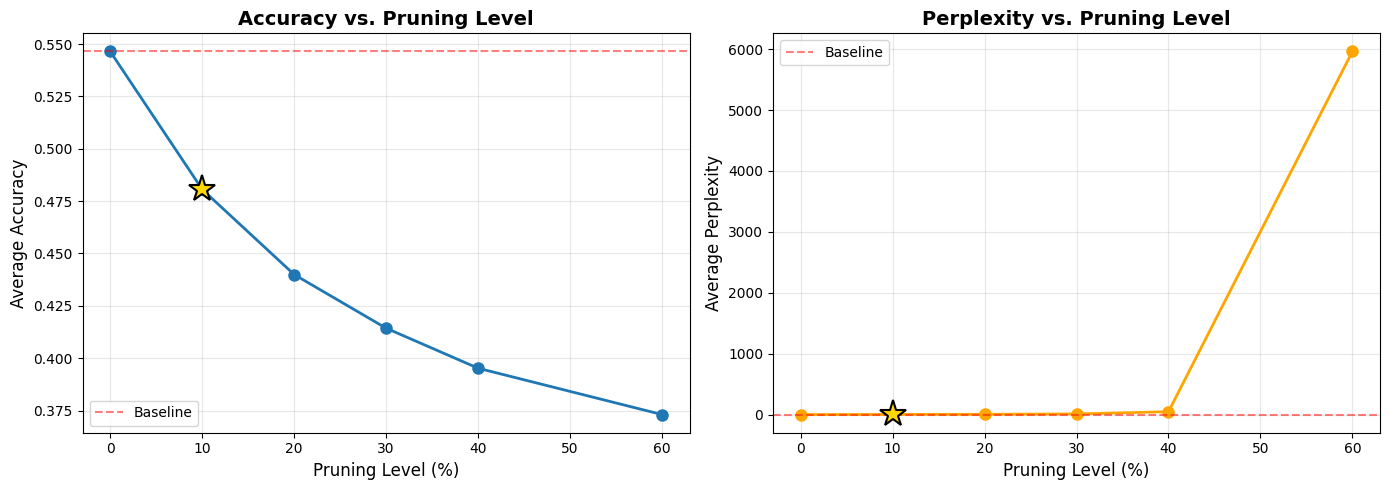


📊 Visualization saved to: /content/drive/MyDrive/glu_pruning/results/llama_1b_performance_analysis.png


In [14]:
# Visualization: Performance across pruning levels
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(summary_df['pruning'], summary_df['avg_accuracy'], marker='o', linewidth=2, markersize=8)
axes[0].axhline(y=baseline_acc, color='r', linestyle='--', alpha=0.5, label='Baseline')
axes[0].set_xlabel('Pruning Level (%)', fontsize=12)
axes[0].set_ylabel('Average Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs. Pruning Level', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Highlight star model
star_idx = summary_df[summary_df['star'] == '⭐'].index[0]
axes[0].plot(summary_df.loc[star_idx, 'pruning'], summary_df.loc[star_idx, 'avg_accuracy'],
             marker='*', markersize=20, color='gold', markeredgecolor='black', markeredgewidth=1.5)

# Perplexity plot
axes[1].plot(summary_df['pruning'], summary_df['avg_perplexity'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].axhline(y=baseline_ppl, color='r', linestyle='--', alpha=0.5, label='Baseline')
axes[1].set_xlabel('Pruning Level (%)', fontsize=12)
axes[1].set_ylabel('Average Perplexity', fontsize=12)
axes[1].set_title('Perplexity vs. Pruning Level', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Highlight star model
axes[1].plot(summary_df.loc[star_idx, 'pruning'], summary_df.loc[star_idx, 'avg_perplexity'],
             marker='*', markersize=20, color='gold', markeredgecolor='black', markeredgewidth=1.5)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/llama_1b_performance_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved to: {RESULTS_DIR}/llama_1b_performance_analysis.png")

# 7. Decision Matrix: Which Models to Upload?

Based on the evaluation results, determine which models should be uploaded to HuggingFace Hub for Phase 2.

In [15]:
import numpy as np # Need numpy for nan checks
import pandas as pd # Ensure pandas is imported

print(f"\n{'='*70}")
print("🎯 DECISION MATRIX: Models for HuggingFace Hub Upload")
print(f"{'='*70}\n")

print("Evaluation Criteria:")
print("  1. Performance degradation (avg_accuracy) < 15% vs baseline")
print("  2. Outperforms or matches baseline in at least 3 tasks (Primary Metric)")
print("  3. Accuracy degradation (avg_accuracy) < 50% vs baseline")
print("  4. Sufficient parameter reduction to justify storage\n")

# --- Setup: Load BENCHMARKS_BASE and Baseline Scores (as before) ---
print("Building primary metric map from BENCHMARKS_BASE...")
TASK_PRIMARY_METRICS = {}
if 'BENCHMARKS_BASE' not in globals():
    print("="*70)
    print("❌ Error: BENCHMARKS_BASE variable not found in global scope.")
    print("   Please ensure you have run the setup cell that imports from utils.py:")
    print("   >>> from utils import BENCHMARKS_BASE")
    print("="*70)
    raise NameError("BENCHMARKS_BASE is not defined.")
else:
    print(f"✅ Found BENCHMARKS_BASE with {len(BENCHMARKS_BASE)} tasks.")

for task_spec in BENCHMARKS_BASE:
    task_name = task_spec["name"]
    if task_name == 'wikitext':
        TASK_PRIMARY_METRICS[task_name] = ('word_perplexity,none', False) # Lower is better
    elif task_name == 'lambada_openai':
        TASK_PRIMARY_METRICS[task_name] = ('perplexity', False) # Lower is better
    elif task_name == 'gsm8k':
        TASK_PRIMARY_METRICS[task_name] = ('exact_match,strict-match', True) # Higher is better
    else:
        TASK_PRIMARY_METRICS[task_name] = ('accuracy', True) # Higher is better
print(f"Built primary metric map for {len(TASK_PRIMARY_METRICS)} tasks.")

try:
    df_baseline = df[df['pruning_pct'] == 0].set_index('task')
    baseline_scores = {}
    for task, (metric, _) in TASK_PRIMARY_METRICS.items():
        if task in df_baseline.index and metric in df_baseline.columns:
            score = df_baseline.loc[task, metric]
            if not pd.isna(score):
                baseline_scores[task] = score
    print(f"Captured {len(baseline_scores)} valid scores from baseline model.")
except Exception as e:
    print(f"❌ Error: Could not get baseline scores from 'df'. {e}")
    baseline_scores = {}
# --- End Setup ---


# Decision logic
decisions = []
if 'summary_df' not in globals():
     print("❌ Error: 'summary_df' not found. Please run the previous analysis cell.")
else:
    for _, row in summary_df.iterrows():
        if row['pruning'] == 0:
            continue  # Skip baseline

        decision = {
            "model": row['model'],
            "pruning": row['pruning'],
            "star": row['star'],
        }

        acc_degradation = abs((row['avg_accuracy'] - baseline_acc) / baseline_acc * 100) if baseline_acc and not pd.isna(row['avg_accuracy']) else 999
        ppl_degradation = abs((row['avg_perplexity'] - baseline_ppl) / baseline_ppl * 100) if baseline_ppl and not pd.isna(row['avg_perplexity']) else 999

        # --- MODIFIED: Check Criterion 2 AND store task names ---
        outperform_count = 0
        outperforming_tasks = []  # <-- NEW: List to store names
        model_tasks_df = df[df['model'] == row['model']].set_index('task')

        for task, (metric, higher_is_better) in TASK_PRIMARY_METRICS.items():
            if task not in baseline_scores or task not in model_tasks_df.index:
                continue

            model_score = model_tasks_df.loc[task, metric]
            if pd.isna(model_score):
                continue

            baseline_score = baseline_scores[task]

            if higher_is_better:
                if model_score >= baseline_score:
                    outperform_count += 1
                    outperforming_tasks.append(task) # <-- NEW: Store task name
            else: # Lower is better
                if model_score <= baseline_score:
                    outperform_count += 1
                    outperforming_tasks.append(task) # <-- NEW: Store task name

        decision['outperform_count'] = outperform_count
        decision['outperforming_tasks'] = outperforming_tasks # <-- NEW: Store list
        tasks_str = ", ".join(outperforming_tasks) if outperforming_tasks else "None"
        # --- End Criterion 2 Check ---


        # --- MODIFIED: Updated Decision Logic with task list ---
        is_star = row['star'] == '⭐'
        crit_1_low_degrad = (acc_degradation < 15)
        crit_2_tasks = (outperform_count >= 3)
        crit_3_not_catastrophic = (acc_degradation < 50)

        if is_star:
            decision['upload'] = True
            decision['reason'] = f"Star model. Won/Tied: {tasks_str}"
        elif crit_1_low_degrad and crit_2_tasks:
            decision['upload'] = True
            decision['reason'] = f"Low degradation (acc: {acc_degradation:.1f}%) AND Won/Tied: {tasks_str}"
        elif crit_3_not_catastrophic and crit_2_tasks:
            decision['upload'] = True
            decision['reason'] = f"Acceptable degradation (acc: {acc_degradation:.1f}%) AND Won/Tied: {tasks_str}"
        else:
            decision['upload'] = False
            reason_parts = []
            if not crit_3_not_catastrophic:
                reason_parts.append(f"High acc degradation ({acc_degradation:.1f}%)")
            if not crit_2_tasks:
                reason_parts.append(f"Only {outperform_count} tasks won ({tasks_str})")

            if not reason_parts:
                 reason_parts.append(f"Degradation (acc: {acc_degradation:.1f}%) or task count ({outperform_count}) too low")

            decision['reason'] = " AND ".join(reason_parts)

        decisions.append(decision)

# Display decision table
print("\nUpload Decisions (Updated Logic with Task Details):")
print("-" * 140) # <-- Widen table
# <-- MODIFIED: Widen Reason column
print(f"{'Model':<35} {'Pruning':<10} {'Star':<6} {'Tasks Won/Tied':<16} {'Upload?':<10} {'Reason'}")
print("-" * 140) # <-- Widen table

for dec in decisions:
    upload_status = "✅ YES" if dec['upload'] else "❌ NO"
    print(f"{dec['model']:<35} {dec['pruning']:<10}% {dec['star']:<6} {dec.get('outperform_count', 'N/A'):<16} {upload_status:<10} {dec['reason']}")

print("-" * 140) # <-- Widen table

# Summary
models_to_upload = sum(1 for d in decisions if d['upload'])
print(f"\n📦 Total models to upload to HF Hub: {models_to_upload}/{len(decisions)}")
print(f"\n✅ PHASE 3 COMPLETE - Ready for Phase 2 (Model Factory)")


🎯 DECISION MATRIX: Models for HuggingFace Hub Upload

Evaluation Criteria:
  1. Performance degradation (avg_accuracy) < 15% vs baseline
  2. Outperforms or matches baseline in at least 3 tasks (Primary Metric)
  3. Accuracy degradation (avg_accuracy) < 50% vs baseline
  4. Sufficient parameter reduction to justify storage

Building primary metric map from BENCHMARKS_BASE...
✅ Found BENCHMARKS_BASE with 13 tasks.
Built primary metric map for 13 tasks.
Captured 11 valid scores from baseline model.

Upload Decisions (Updated Logic with Task Details):
--------------------------------------------------------------------------------------------------------------------------------------------
Model                               Pruning    Star   Tasks Won/Tied   Upload?    Reason
--------------------------------------------------------------------------------------------------------------------------------------------
Llama-3.2-3B-pruned-10%             10        % ⭐      0                ✅

In [16]:
print(f"\n{'='*70}")
print("💾 SAVING COMPLETE RESULTS FOR RESEARCH SHARING")
print(f"{'='*70}\n")

# --- Dynamic Model Info Setup ---
# Build a lookup for expansion rates from EXPERIMENT_CONFIG (if it exists)
exp_rate_map = {}
if 'EXPERIMENT_CONFIG' in globals():
    try:
        # --- ROBUST PARSING ---
        # Only add if all keys are present
        for cfg in EXPERIMENT_CONFIG:
            if (cfg.get("base_model", "") == "meta-llama/Llama-3.2-1B"
                and 'pruning_pct' in cfg
                and 'expansion_rate' in cfg):
                 exp_rate_map[cfg['pruning_pct']] = cfg['expansion_rate']
    except Exception as e:
        print(f"⚠️ Warning: Could not parse EXPERIMENT_CONFIG. {e}")
exp_rate_map[0] = 300 # Baseline expansion rate

print(f"Loaded {len(exp_rate_map)} expansion rates from config (Baseline included).")

# Build 'models_evaluated' section dynamically from the 'df'
models_evaluated = {}
if 'df' not in globals():
    print("❌ Error: 'df' DataFrame not found. Cannot build results.")
    raise NameError("'df' is not defined. Please run consolidation cell.")

# Group by model to rebuild the nested result structure
grouped_by_model = df.groupby(['model', 'pruning_pct', 'is_star'])

for (model_name, pruning_pct, is_star_bool), model_df in grouped_by_model:
    model_key = f"pruned_{int(pruning_pct)}pct" if pruning_pct > 0 else "baseline"

    # Rebuild the nested results dict
    model_results_dict = {}
    for _, row in model_df.iterrows():
        task_name = row['task']
        metrics = row.drop(['model', 'pruning_pct', 'is_star', 'task'])

        task_metrics = {}
        for col, val in metrics.dropna().items():
            # Convert numpy types to native Python types
            if isinstance(val, (np.integer, np.int64)):
                task_metrics[col] = int(val)
            elif isinstance(val, (np.floating, np.float64)):
                task_metrics[col] = float(val)
            else:
                task_metrics[col] = val
        model_results_dict[task_name] = task_metrics

    # Assemble the entry for this model
    models_evaluated[model_key] = {
        "name": model_name,
        "pruning_pct": int(pruning_pct), # Cast to native int
        "expansion_rate": exp_rate_map.get(int(pruning_pct), None), # Get from map
        "is_star": bool(is_star_bool), # <--- *** CRITICAL FIX: Cast to native bool ***
        "hf_repo": (
            "meta-llama/Llama-3.2-1B" if pruning_pct == 0
            else f"peremartra/Llama-3.2-1B-pruned-{int(pruning_pct)}pct"
        ),
        "results": model_results_dict
    }
print(f"Dynamically built {len(models_evaluated)} model entries from 'df'.")
# --- End Dynamic Model Setup ---


# Consolidate all data into a comprehensive JSON
complete_results = {
    "experiment_metadata": {
        "timestamp": datetime.now().isoformat(),
        "notebook": "02_Evaluate_1B.ipynb",
        "model_family": "Llama-3.2-1B",
        "pruning_method": "MAW (Maximum Absolute Weight)",
        #"library_versions": library_versions,
        "hardware": {
            "device": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU",
            "gpu_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else None
        }
    },

    "benchmarks": [
        {"name": task["name"], "num_fewshot": task["num_fewshot"]}
        for task in BENCHMARKS_BASE
    ],

    "models_evaluated": models_evaluated, # Use dynamic model data

    "summary_statistics": {
        "baseline": {
            "avg_accuracy": float(summary_df.loc[summary_df['pruning'] == 0, 'avg_accuracy'].values[0]),
            "avg_perplexity": float(summary_df.loc[summary_df['pruning'] == 0, 'avg_perplexity'].values[0]),
        },
        "pruned_models": [
            {
                "pruning_pct": int(row['pruning']),
                "is_star": row['star'] == '⭐', # This is native bool, so it's fine
                "avg_accuracy": float(row['avg_accuracy']) if pd.notna(row['avg_accuracy']) else None,
                "avg_perplexity": float(row['avg_perplexity']) if pd.notna(row['avg_perplexity']) else None,
                "accuracy_degradation_pct": float(((row['avg_accuracy'] - baseline_acc) / baseline_acc * 100)) if baseline_acc and pd.notna(row['avg_accuracy']) else None,
                "perplexity_degradation_pct": float(((row['avg_perplexity'] - baseline_ppl) / baseline_ppl * 100)) if baseline_ppl and pd.notna(row['avg_perplexity']) else None
            }
            for _, row in summary_df.iterrows() if row['pruning'] > 0
        ]
    },

    "upload_decisions": decisions, # Use dynamic decisions

    "citation": {
        "paper": "Exploring GLU Expansion Ratios: Structured Pruning in Llama-3.2 Models",
        "author": "Pere Martra",
        "doi": "https://doi.org/10.31219/osf.io/qgxea",
        "github": "https://github.com/peremartra/llama-glu-expansion-pruning",
        "note": "Results are freely available for research purposes. Please cite the paper if you use this data."
    }
}

# --- Save to JSON ---
try:
    # Ensure RESULTS_DIR is defined
    if 'RESULTS_DIR' not in globals():
        print("❌ Error: RESULTS_DIR not defined. Defaulting to './results'")
        RESULTS_DIR = "./results"

    # Create RESULTS_DIR if it doesn't exist
    os.makedirs(RESULTS_DIR, exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    json_path = f"{RESULTS_DIR}/llama_1b_complete_results_{timestamp}.json"
    with open(json_path, 'w') as f:
        json.dump(complete_results, f, indent=2, ensure_ascii=False)

    print(f"✅ Complete results saved to:")
    print(f"   {json_path}")

    # Also save a "latest" version
    latest_json = f"{RESULTS_DIR}/llama_1b_complete_results_latest.json"
    with open(latest_json, 'w') as f:
        json.dump(complete_results, f, indent=2, ensure_ascii=False)

    print(f"✅ Latest version:")
    print(f"   {latest_json}")

    # Display file size
    file_size_kb = Path(json_path).stat().st_size / 1024
    print(f"\n📊 File size: {file_size_kb:.1f} KB")

except Exception as e:
    print(f"❌ Error saving JSON files: {e}")
    print(f"   Please ensure RESULTS_DIR is defined and writeable: {RESULTS_DIR}")


print(f"\n📦 Models included: {len(complete_results['models_evaluated'])}")
print(f"📋 Benchmarks per model: {len(BENCHMARKS_BASE)}")
print(f"🔬 Total result entries: {len(df)}")

print(f"\n{'='*70}")
print("✅ COMPLETE RESULTS SAVED - Ready for research sharing")
# --- THIS IS THE CORRECTED LINE ---
print(f"{'='*70}\n")


💾 SAVING COMPLETE RESULTS FOR RESEARCH SHARING

Loaded 1 expansion rates from config (Baseline included).
Dynamically built 6 model entries from 'df'.
✅ Complete results saved to:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_complete_results_20251028_063827.json
✅ Latest version:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_complete_results_latest.json

📊 File size: 15.6 KB

📦 Models included: 6
📋 Benchmarks per model: 13
🔬 Total result entries: 78

✅ COMPLETE RESULTS SAVED - Ready for research sharing



---

## 🎓 Key Takeaways

This notebook evaluated the Llama-3.2-1B/3B model family across 11 comprehensive benchmarks to determine:

1. **Optimal pruning level** for GLU-MLP layers
2. **Performance-efficiency trade-offs** at different expansion ratios
3. **Which models justify upload** to HuggingFace Hub


---

**Powered by OptiPFair** - Structured Pruning for GLU Architectures

If this research helps your work:
- ⭐ Star [the repo](https://github.com/peremartra/optipfair)
- 📖 Read the [documentation](https://peremartra.github.io/optipfair/)
- 🐛 Report issues or suggest features

---